# Title: Excersises for Chapter 12

Sanjay Jaras

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf

%matplotlib inline
from IPython.display import set_matplotlib_formats

import regression
import thinkplot
import timeseries
import thinkstats2

set_matplotlib_formats("png", "pdf")
plt.rcParams["figure.figsize"] = [16, 12]

## Exercise 12.1 
The linear model I used in this chapter has the obvious draw-
back that it is linear, and there is no reason to expect prices to change linearly
over time. We can add flexibility to the model by adding a quadratic term,
as we did in Section 11.3.
Use a quadratic model to fit the time series of daily prices, and use the model
to generate predictions. You will have to write a version of RunLinearModel
that runs that quadratic model, but after that you should be able to reuse
code in timeseries.py to generate predictions.

### Define model function

In [2]:
def RunQuadraticModel(daily):
    """Runs a linear model of prices versus years.

    daily: DataFrame of daily prices

    returns: model, results
    """
    model = smf.ols("ppg ~ years + years2", data=daily)
    results = model.fit()
    return model, results

### Load Data and create daily records for quality

In [3]:
# Load data
transactions = timeseries.ReadData()
# Group data by Quality and daty and returns dictionary as quality as key  records for quality as values
# columns in data are ppg date and years
dailies = timeseries.GroupByQualityAndDay(transactions)
name = "high"

# get data for quality high
daily = dailies[name]

# Add column with quadratic value for years
daily["years2"] = daily.years ** 2

### Plot for Model and Fitted values

Intercept   13.7   (0)
years   -1.12   (5.86e-38)
years2   0.113   (4.82e-07)
R^2 0.4553
Std(ys) 1.096
Std(res) 0.809


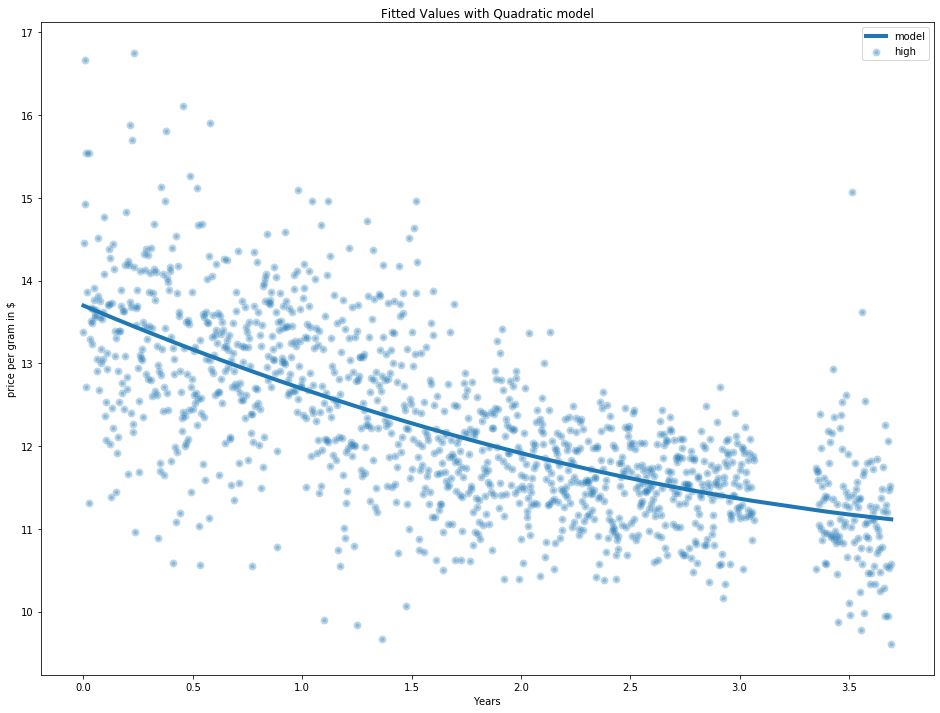

In [4]:
model, results = RunQuadraticModel(daily)
regression.SummarizeResults(results)
years = model.exog[:, 1]
values = model.endog
plt.plot(years, results.fittedvalues, lineWidth=4)
plt.scatter(years, values, s=15, alpha=0.3, lineWidth=4)
plt.xlabel("Years")
plt.ylabel("price per gram in $")
plt.title("Fitted Values with Quadratic model")
plt.legend(["model", "high"])
plt.show()

### Plot for residuals

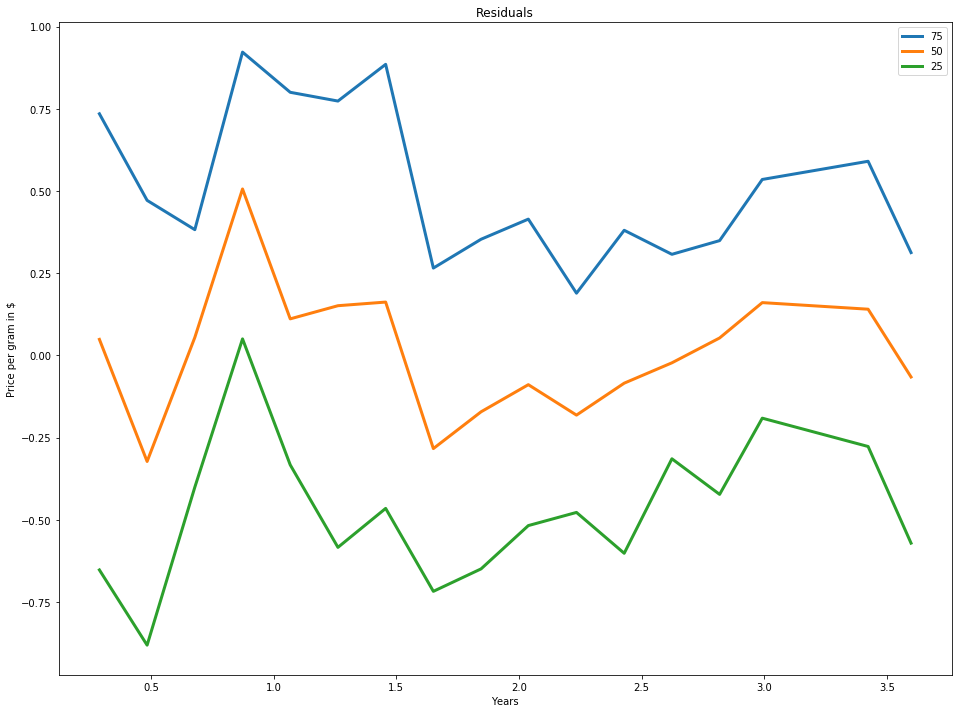

In [5]:
num_bins=20
resid = results.resid.values
df = pd.DataFrame(dict(exog=years, resid=resid))

bins = np.linspace(np.min(years), np.max(years), num_bins)
indices = np.digitize(years, bins)
groups = df.groupby(indices)

means = [group.exog.mean() for _, group in groups][1:-1]
cdfs = [thinkstats2.Cdf(group.resid) for _, group in groups][1:-1]

percentsFor = [75, 50, 25]
for percent in percentsFor:
    percentiles = [cdf.Percentile(percent) for cdf in cdfs]
    label = "%dth" % percent
    plt.plot(means, percentiles, lineWidth=3)
plt.legend(percentsFor)
plt.title("Residuals")
plt.xlabel("Years")
plt.ylabel("Price per gram in $")
plt.show()

### Plot for Predictions

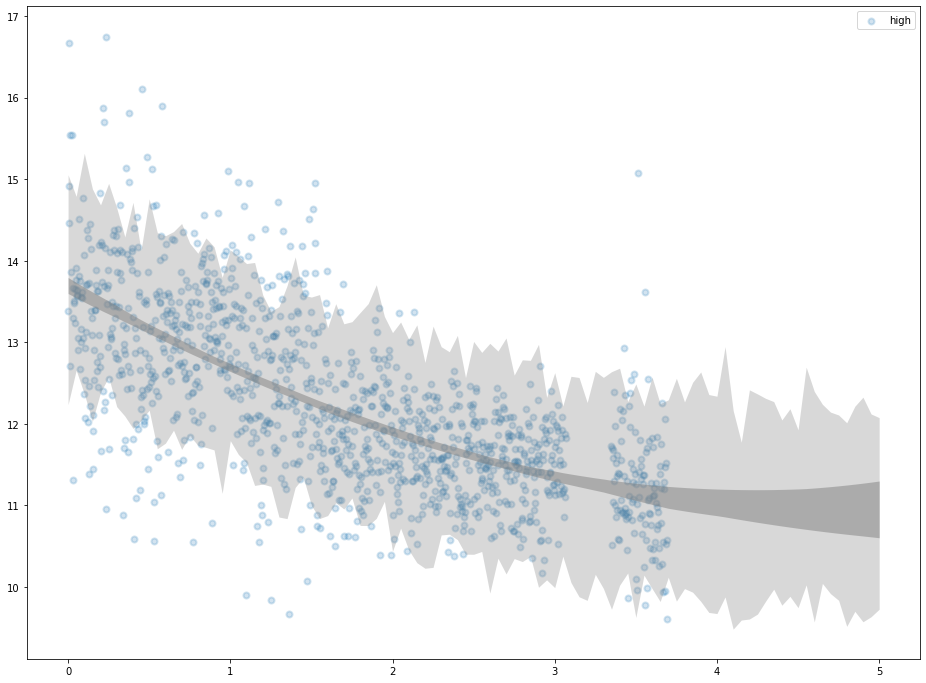

In [6]:
years = np.linspace(0, 5, 101)
plt.scatter(daily.years, daily.ppg, alpha=0.2, lineWidth=2)
timeseries.PlotPredictions(daily, years, func=RunQuadraticModel)
plt.legend(["high"])

## Exercise 12.2 
Write a definition for a class named SerialCorrelationTest
that extends HypothesisTest from Section 9.2. It should take a series and
a lag as data, compute the serial correlation of the series with the given lag,
and then compute the p-value of the observed correlation.
Use this class to test whether the serial correlation in raw price data is
statistically significant. Also test the residuals of the linear model and (if
you did the previous exercise), the quadratic model.

### Define class SerialCorrelationTest

In [7]:
class SerialCorrelationTest(thinkstats2.HypothesisTest):
    """Tests serial correlations by permutation."""

    def TestStatistic(self, data):
        """Computes the test statistic.

        data: tuple of Series and lag
        """
        series, lag = data
        test_stat = abs(thinkstats2.SerialCorr(series, lag))
        return test_stat

    def RunModel(self):
        """Run the model of the null hypothesis.

        returns: simulated data
        """
        series, lag = self.data
        permutation = series.reindex(np.random.permutation(series.index))
        return permutation, lag
    

### Test SerialCorrelation for Price per Gram

In [8]:
series = daily.ppg
test = SerialCorrelationTest((series, 1))
pvalue = test.PValue()
print(test.actual, pvalue)

0.485229376194738 0.0


### Test Serial Correlation for Residuals

In [9]:
# test for serial correlation in residuals of the linear model
_, results = timeseries.RunLinearModel(daily)
series = results.resid
test = SerialCorrelationTest((series, 1))
pvalue = test.PValue()
print(test.actual, pvalue)



0.07570473767506261 0.012


### Test SerialCorrlation for Quadratic model

In [10]:
# test for serial correlation in residuals of the quadratic model
_, results = RunQuadraticModel(daily)
series = results.resid
test = SerialCorrelationTest((series, 1))
pvalue = test.PValue()
print(test.actual, pvalue)

0.056073081612899194 0.051
